# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [2]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg, col, concat, desc, explode, lit, min, max, split, udf, count
from pyspark.sql.types import IntegerType

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import CountVectorizer, IDF, Normalizer, PCA, RegexTokenizer, StandardScaler, StopWordsRemover, StringIndexer, VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

import re

# Load and Clean Dataset
Clean your dataset, checking for invalid or missing data. For example, records without userids or sessionids. In this workspace, the filename is `mini_sparkify_event_data.json`.

In [3]:
import ibmos2spark
# @hidden_cell
credentials = {
    'endpoint': 'https://s3-api.us-geo.objectstorage.service.networklayer.com',
    'service_id': 'iam-ServiceId-27414cb1-6f23-43f7-b5c4-068f7ddd28df',
    'iam_service_endpoint': 'https://iam.bluemix.net/oidc/token',
    'api_key': 'XqTOGm6hBHQPBph0av9FxudyXZZx7phmmVrkAVZN05NE'
}

configuration_name = 'os_7bc372256f5b42afa24a39e2c2637134_configs'
cos = ibmos2spark.CloudObjectStorage(sc, credentials, configuration_name, 'bluemix_cos')

from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
# Since JSON data can be semi-structured and contain additional metadata, it is possible that you might face issues with the DataFrame layout.
# Please read the documentation of 'SparkSession.read()' to learn more about the possibilities to adjust the data loading.
# PySpark documentation: http://spark.apache.org/docs/2.0.2/api/python/pyspark.sql.html#pyspark.sql.DataFrameReader.json

df = spark.read.json(cos.url('medium-sparkify-event-data.json', 'sparkify-donotdelete-pr-ldhntltm3yvkv2'))
df.take(5)


[Row(artist='Martin Orford', auth='Logged In', firstName='Joseph', gender='M', itemInSession=20, lastName='Morales', length=597.55057, level='free', location='Corpus Christi, TX', method='PUT', page='NextSong', registration=1532063507000, sessionId=292, song='Grand Designs', status=200, ts=1538352011000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', userId='293'),
 Row(artist="John Brown's Body", auth='Logged In', firstName='Sawyer', gender='M', itemInSession=74, lastName='Larson', length=380.21179, level='free', location='Houston-The Woodlands-Sugar Land, TX', method='PUT', page='NextSong', registration=1538069638000, sessionId=97, song='Bulls', status=200, ts=1538352025000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"', userId='98'),
 Row(artist='Afroman', auth='Logged In', firstName='Maverick', gender='M', 

In [4]:
df.persist()

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string]

In [5]:
df_valid = df.dropna(how = "any", subset = ["userId", "sessionId"])

In [6]:
df_valid.select("userId").dropDuplicates().sort("userId").show()

+------+
|userId|
+------+
|      |
|    10|
|   100|
|100001|
|100002|
|100003|
|100004|
|100005|
|100006|
|100007|
|100008|
|100009|
|100010|
|100011|
|100012|
|100013|
|100014|
|100015|
|100016|
|100017|
+------+
only showing top 20 rows



In [7]:
df_valid.select("sessionId").dropDuplicates().sort("userId").show()

+---------+
|sessionId|
+---------+
|       54|
|     3069|
|     1677|
|     2944|
|      720|
|      222|
|     2214|
|     2529|
|     3506|
|     1280|
|      191|
|     3199|
|     1277|
|     3280|
|     1371|
|     4126|
|      541|
|     1840|
|     3327|
|     3009|
+---------+
only showing top 20 rows



In [8]:
df_valid = df_valid.filter(df["userId"] != "")

In [9]:
df_valid.count()

528005

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [10]:
# see what values page feature holds
df_valid.select("page").dropDuplicates().show()

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
|            Settings|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
+--------------------+



In [11]:
# create a list for churn users
churn_user_df = df.filter(df.page=="Cancellation Confirmation").select("userId").dropDuplicates()
churn_user_list = [user["userId"] for user in churn_user_df.collect()]

In [12]:
# create a column for churn
df_valid = df_valid.withColumn("churn", df_valid.userId.isin(churn_user_list))

#### investigate the gender difference by two groups.

In [13]:
# show gender difference in churn
df_valid.dropDuplicates(['userId']).groupby(['gender','churn']).count().show()

+------+-----+-----+
|gender|churn|count|
+------+-----+-----+
|     M| true|   54|
|     F|false|  153|
|     F| true|   45|
|     M|false|  196|
+------+-----+-----+



In [14]:
churn_rate_of_female = 20/(20+84) 
churn_rate_of_male = 32/(32+89)
print("churn rate of female is ",churn_rate_of_female)
print("churn rate of male is ",churn_rate_of_male)


churn rate of female is  0.19230769230769232
churn rate of male is  0.2644628099173554


#### investigate the number of songs played by two groups.

In [15]:
df_valid_songs = df_valid.where(df_valid.song!='null').groupby(['churn','userId']) \
    .agg(count(df_valid.song).alias('SongsPlayed')).orderBy('churn').toPandas()

In [16]:
df_valid_songs.hist(['SongsPlayed'], by='churn', sharex=True, sharey=True)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x2b9e0ffc7ac8>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x2b9e1bf07748>], dtype=object)

#### investigate the average numbers of thumps-up and thumps-down by two groups.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x2b9e1c049668>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x2b9e1c05b4e0>], dtype=object)

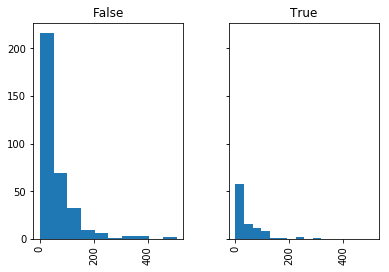

In [17]:
df_valid_thumbsup = df_valid.where(df_valid.page=='Thumbs Up') \
    .groupby(['churn','userId']).agg(count(col('page')).alias('ThumbsUps')).orderBy('churn').toPandas()
df_valid_thumbsup.hist('ThumbsUps', by='churn', sharex=True, sharey=True)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x2b9e1c0e7cc0>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x2b9e1c0f8b00>], dtype=object)

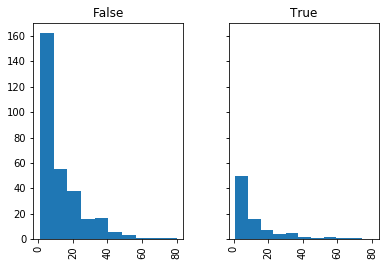

In [18]:
df_valid_thumbsdown = df_valid.where(df_valid.page=='Thumbs Down') \
    .groupby(['churn','userId']).agg(count(col('page')).alias('ThumbsDowns')).orderBy('churn').toPandas()
df_valid_thumbsdown.hist('ThumbsDowns', by='churn', sharex=True, sharey=True)

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

##### pick gender as first feature

In [19]:
df_gender = df_valid.dropDuplicates(['userId']).sort('userId').select(['userId','gender'])
df_gender = df_gender.replace(['F','M'], ['1', '0'], 'gender')
df_gender.withColumn('gender', df_gender.gender.cast("int"))

DataFrame[userId: string, gender: int]

In [20]:
df_gender.show()

+------+------+
|userId|gender|
+------+------+
|    10|     0|
|   100|     0|
|100001|     1|
|100002|     1|
|100003|     1|
|100004|     1|
|100005|     0|
|100006|     1|
|100007|     1|
|100008|     1|
|100009|     0|
|100010|     1|
|100011|     0|
|100012|     0|
|100013|     1|
|100014|     0|
|100015|     1|
|100016|     0|
|100017|     0|
|100018|     0|
+------+------+
only showing top 20 rows



##### pick number of songs played as second feature

In [21]:
df_songs = df_valid.where(df_valid.song!='null').groupby('userId') \
    .agg(count(df_valid.song).alias('SongsPlayed')).orderBy('userId') \
    .select(['userId','SongsPlayed'])

In [22]:
df_songs.show()

+------+-----------+
|userId|SongsPlayed|
+------+-----------+
|    10|        360|
|   100|       3382|
|100001|         96|
|100002|        137|
|100003|        661|
|100004|        262|
|100005|         72|
|100006|        295|
|100007|        853|
|100008|        386|
|100009|       2412|
|100010|         96|
|100011|       1021|
|100012|        112|
|100013|         20|
|100014|        332|
|100015|        381|
|100016|        163|
|100017|        127|
|100018|        124|
+------+-----------+
only showing top 20 rows



##### pick number of thumbs up and thumps down as third and fourth feature

In [23]:
df_thumbsup = df_valid.where(df_valid.page=='Thumbs Up') \
    .groupby(['userId']).agg(count(col('page')).alias('ThumbsUps')).orderBy('userId').select(['userId','ThumbsUps'])

In [24]:
df_thumbsdown = df_valid.where(df_valid.page=='Thumbs Down') \
    .groupby(['userId']).agg(count(col('page')).alias('ThumbsDowns')).orderBy('userId').select(['userId','ThumbsDowns'])

##### pick the number of singers user has listened as fifth feature

In [25]:
df_singers = df_valid.dropDuplicates(['userId','artist']).groupby('userId') \
    .agg(count(df_valid.artist).alias('SingersListened')).orderBy('userId') \
    .select(['userId','SingersListened'])

In [26]:
df_singers.show()

+------+---------------+
|userId|SingersListened|
+------+---------------+
|    10|            306|
|   100|           1963|
|100001|             93|
|100002|            128|
|100003|            545|
|100004|            242|
|100005|             69|
|100006|            261|
|100007|            680|
|100008|            336|
|100009|           1543|
|100010|             94|
|100011|            769|
|100012|            109|
|100013|             20|
|100014|            292|
|100015|            346|
|100016|            150|
|100017|            124|
|100018|            117|
+------+---------------+
only showing top 20 rows



#### join together different features

In [27]:
df_final = df_valid.dropDuplicates(['userId']).sort('userId').select(['userId','churn'])
for feature in [df_gender, df_songs,df_thumbsup,df_thumbsdown,df_singers]:
    df_final = df_final.join(feature,'userId')

In [28]:
df_final.show()

+------+-----+------+-----------+---------+-----------+---------------+
|userId|churn|gender|SongsPlayed|ThumbsUps|ThumbsDowns|SingersListened|
+------+-----+------+-----------+---------+-----------+---------------+
|100010| true|     1|         96|        4|          3|             94|
|200002| true|     0|        310|       15|          5|            287|
|   125|false|     0|         62|        3|          1|             61|
|   124| true|     1|       1826|      102|         15|           1240|
|    51| true|     0|        266|       16|          1|            233|
|     7|false|     0|        462|       12|          4|            407|
|200037| true|     0|        122|        5|          3|            114|
|   205|false|     1|       1048|       50|         10|            803|
|   272|false|     1|         97|        7|          4|             93|
|    15|false|     0|       1835|       93|         16|           1286|
|   232|false|     1|       1876|       97|         17|         

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [29]:
df_final.groupby("churn").count().show()

+-----+-----+
|churn|count|
+-----+-----+
| true|   89|
|false|  299|
+-----+-----+



In [30]:
df_final.dtypes

[('userId', 'string'),
 ('churn', 'boolean'),
 ('gender', 'string'),
 ('SongsPlayed', 'bigint'),
 ('ThumbsUps', 'bigint'),
 ('ThumbsDowns', 'bigint'),
 ('SingersListened', 'bigint')]

In [31]:
# convert data type of columns into float
for feature in df_final.columns[1:]:
    df_final = df_final.withColumn(feature,df_final[feature].cast('float'))

In [32]:
df_final.dtypes

[('userId', 'string'),
 ('churn', 'float'),
 ('gender', 'float'),
 ('SongsPlayed', 'float'),
 ('ThumbsUps', 'float'),
 ('ThumbsDowns', 'float'),
 ('SingersListened', 'float')]

#### split the data into train and test

In [33]:
df_final.show(5)

+------+-----+------+-----------+---------+-----------+---------------+
|userId|churn|gender|SongsPlayed|ThumbsUps|ThumbsDowns|SingersListened|
+------+-----+------+-----------+---------+-----------+---------------+
|100010|  1.0|   1.0|       96.0|      4.0|        3.0|           94.0|
|200002|  1.0|   0.0|      310.0|     15.0|        5.0|          287.0|
|   125|  0.0|   0.0|       62.0|      3.0|        1.0|           61.0|
|   124|  1.0|   1.0|     1826.0|    102.0|       15.0|         1240.0|
|    51|  1.0|   0.0|      266.0|     16.0|        1.0|          233.0|
+------+-----+------+-----------+---------+-----------+---------------+
only showing top 5 rows



In [34]:
train, test = df_final.randomSplit([0.9, 0.1], seed=42)

#### build pipeline for logistic regression model

In [35]:
assembler = VectorAssembler(inputCols=df_final.columns[1:],outputCol='featuresassemble')
scaler = StandardScaler(inputCol="featuresassemble", outputCol="features", withStd=True)
indexer = StringIndexer(inputCol="churn", outputCol="label")

lr =  LogisticRegression(maxIter=10, regParam=0.0, elasticNetParam=0)

stringIndexer = StringIndexer(inputCol="label", outputCol="indexed")
rf = RandomForestClassifier(numTrees=3, maxDepth=2, labelCol="indexed", seed=42)

In [36]:
pipeline_lr = Pipeline(stages=[assembler, scaler, indexer, lr])

paramGrid_lr = ParamGridBuilder() \
    .addGrid(lr.regParam,[0.0, 0.1, 0.01]) \
    .build()


crossval_lr = CrossValidator(estimator=pipeline_lr,
                          estimatorParamMaps=paramGrid_lr,
                          evaluator=BinaryClassificationEvaluator(),
                          numFolds=3)

In [37]:
cvModel_lr = crossval_lr.fit(train)

In [38]:
cvModel_lr.avgMetrics

[1.0, 1.0, 1.0]

In [39]:
results = cvModel_lr.transform(test)

#### compute F1 score for test data for logistic regression model

In [40]:
tp = results.filter("label = 1 and prediction = 1").count()
fp = results.filter("label = 0 and prediction = 1").count()
fn = results.filter("label = 1 and prediction = 0").count()
precision = tp / (tp + fp) 
recall = tp / (tp + fn)
f1 = 2*precision*recall / (precision+recall)
print(precision)
print(recall)
print(f1)

1.0
1.0
1.0


#### build pipeline for random forest

In [41]:
pipeline_rf = Pipeline(stages=[assembler, scaler, indexer, stringIndexer, rf])

paramGrid_rf = ParamGridBuilder() \
    .addGrid(rf.numTrees,[10, 20, 30]) \
    .build()


crossval_rf = CrossValidator(estimator=pipeline_rf,
                          estimatorParamMaps=paramGrid_rf,
                          evaluator=BinaryClassificationEvaluator(),
                          numFolds=3)

#### compute F1 score for test data for random forest model

In [42]:
cvModel_rf = crossval_rf.fit(train)

In [43]:
cvModel_rf.avgMetrics

[1.0, 1.0, 1.0]

In [44]:
results = cvModel_rf.transform(test)

In [45]:
tp = results.filter("label = 1 and prediction = 1").count()
fp = results.filter("label = 0 and prediction = 1").count()
fn = results.filter("label = 1 and prediction = 0").count()

precision = tp / (tp + fp) 
recall = tp / (tp + fn)

f1 = 2*precision*recall / (precision+recall)
print(precision)
print(recall)
print(f1)

1.0
1.0
1.0


# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.